importing some liberaries

In [50]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_iris
iris = load_iris()
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

importing the dataset

In [51]:
x = pd.read_csv("tweets-train-data.csv", header= None, usecols= [0], names=["message"])
y = pd.read_csv("tweets-train-targets.csv", header= None, usecols= [0], names=["label"])
x.head()

,message
0,thank you for describing your experience deali...
1,i will be making a major speech on illegal imm...
2,we cant afford a trump presidency this video w...
3,taking it all in
4,thank you four new poll with the movement winn...


In [52]:
x2 = pd.read_csv("tweets-test-data.csv", header= None, usecols= [0], names=["message"])
y2 = pd.read_csv("tweets-test-targets.csv", header= None, usecols= [0], names=["label"])

In [53]:
y.head()

,label
0,HC
1,DT
2,HC
3,HC
4,DT


This is what are data set looks like

In [54]:
tweet = pd.concat([y, x], axis=1, join='inner')
tweet.head()

,label,message
0,HC,thank you for describing your experience deali...
1,DT,i will be making a major speech on illegal imm...
2,HC,we cant afford a trump presidency this video w...
3,HC,taking it all in
4,DT,thank you four new poll with the movement winn...


In [55]:
tweet.label.value_counts()

HC    2427
DT    2406
Name: label, dtype: int64

In [80]:
tweet2 = pd.concat([y2, x2], axis=1, join='inner')

In [57]:
tweets = pd.concat([tweet,tweet2])
tweets.label.value_counts()

HC    3226
DT    3218
Name: label, dtype: int64

now we only have 1 data set called tweets

## why we do this?
in sklearn it is required to classify your data set

In [58]:
tweets['label_num'] = tweets.label.map({'HC':0, 'DT':1})
tweets.head()

,label,message,label_num
0,HC,thank you for describing your experience deali...,0
1,DT,i will be making a major speech on illegal imm...,1
2,HC,we cant afford a trump presidency this video w...,0
3,HC,taking it all in,0
4,DT,thank you four new poll with the movement winn...,1



## here we make x, one dimention:
because it's going to be transformed to 2 dimentional data by count vectorizer

In [59]:
x3= tweets.message
y3 = tweets.label_num
print(x3.shape)
print(y3.shape)

(6444,)
(6444,)


In [60]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x3, y3, random_state=1)
print(X_train.shape)

print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4833,)
(1611,)
(4833,)
(1611,)


# vectorizing our dataset


In [61]:
# instantiate the vectorizer
vect = CountVectorizer()

In [62]:
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [63]:
X_train_dtm = vect.fit_transform(X_train)

In [64]:
X_train_dtm

<4833x6919 sparse matrix of type '<class 'numpy.int64'>'
	with 69127 stored elements in Compressed Sparse Row format>

2416 is the number of rows in x_train 

3809 is the number if words(tokens)

In [65]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1611x6919 sparse matrix of type '<class 'numpy.int64'>'
	with 22278 stored elements in Compressed Sparse Row format>


# building and evaluating our model 


we are gonna use multinomial Naive Bayes

In [66]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [67]:
# train the model using X_train_dtm 
%time nb.fit(X_train_dtm, y_train)

Wall time: 2.99 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [68]:
y_pred_class = nb.predict(X_test_dtm)

### using k-fold cross validation

In [69]:
from sklearn.svm import SVC

clf = SVC(C=10, kernel='rbf', gamma=0.02)

try:
    from sklearn.model_selection import KFold, cross_val_score
    legacy = False 
except ImportError:
    from sklearn.cross_validation import KFold, cross_val_score
    legacy = True
    
# 3-fold cross-validation
# random_state ensures same split for each value of gamma
# KFold has a different syntax for legacy versions of scikit-learn
if legacy:
    kf = KFold(len(y_train),n_folds=3, shuffle=True, random_state=42)
else:
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

gamma_values = [0.1, 0.05, 0.02, 0.01]
accuracy_scores = []

# Do model selection over all the possible values of gamma 
for gamma in gamma_values:
    
    # Train a classifier with current gamma
    clf = SVC(C=10, kernel='rbf', gamma=gamma)

    # Compute cross-validated accuracy scores
    # So legacy....
    if legacy: 
        scores = cross_val_score(clf, X_train_dtm, y_train, cv=kf, scoring='accuracy')
    else:
         scores = cross_val_score(clf, X_train_dtm, y_train, cv=kf.split(X_train_dtm), scoring='accuracy')
    
    # Compute the mean accuracy and keep track of it
    accuracy_score = scores.mean()
    accuracy_scores.append(accuracy_score)

# Get the gamma with highest mean accuracy
best_index = np.array(accuracy_scores).argmax()
best_gamma = gamma_values[best_index]

# Train over the full training set with the best gamma
clf = SVC(C=10, kernel='rbf', gamma=best_gamma)
clf.fit(X_train_dtm, y_train)

# Evaluate on the test set
y_pred = clf.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred_class)

accuracy

0.9013035381750466

our model has a 90% accuracy

In [71]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[740,  67],
       [ 92, 712]], dtype=int64)

TN     ,   FP

FN     ,   TP

In [72]:
tt=metrics.confusion_matrix(y_test, y_pred_class)

In [76]:
from sklearn import metrics

report = metrics.classification_report(y_test, y_pred_class)

# the support is the number of instances having the given label in y_test
print(report)

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       807
           1       0.91      0.89      0.90       804

   micro avg       0.90      0.90      0.90      1611
   macro avg       0.90      0.90      0.90      1611
weighted avg       0.90      0.90      0.90      1611



# the lurning curve:

In [77]:
from sklearn.svm import SVC

# Specify the parameters in the constructor.
# C is the parameter of the primal problem of the SVM;
# The rbf kernel is the Gaussian kernel;
# The rbf kernel takes one parameter: gamma (gaussian width)
clf = SVC(C=10, kernel='rbf', gamma=0.02)

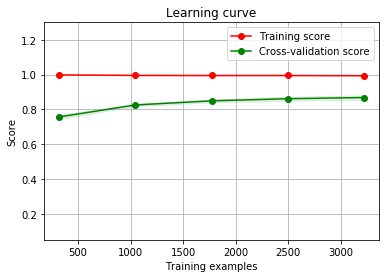

In [79]:
try:
    from sklearn.model_selection import learning_curve
except ImportError:
    from sklearn.learning_curve import learning_curve
    
    
plt.figure()
plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

clf = SVC(C=10, kernel='rbf', gamma=best_gamma)

# Compute the scores of the learning curve
# by default the (relative) dataset sizes are: 10%, 32.5%, 55%, 77.5%, 100%
# The function automatuically executes a Kfold cross validation for each dataset size
train_sizes, train_scores, val_scores = learning_curve(clf, X_train_dtm, y_train, scoring='accuracy', cv=3)

# Get the mean and std of train and validation scores over the cv folds along the varying dataset sizes
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the mean  for the training scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

# Plot the  std for the training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")

# Plot the mean  for the validation scores
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

# Plot the std for the validation scores
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.ylim(0.05,1.3)             # set bottom and top limits for y axis
plt.legend()
plt.show()

In [41]:
#with open ("test-pred.txt", "w") as outfile:
  #  outfile.write(X_test)